## Features reduction

In [25]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb

df = pd.read_excel("../data/HH_SURVEY1/UG_HH_NEW_continuous_no200_train.xls")

df_full = pd.read_excel("../data/UG_HH_NEW_continuous_no200.xls")
df_min = df_full.min()
df_max = df_full.max()

#Drop 'protected' features
drop_cols = ['prop', 'other_prop', 'other_resp']
df = df[[col for col in df if col not in drop_cols]]

df.head()

,time_spent_risk,cells,selfish,time_spent_prop,count_effort,Honesty_Humility,Extraversion,Agreeableness,min_offer
0,43000,26,60,31000,20,4.2,3.0,2.8,50
1,12000,7,20,38000,20,1.9,4.4,2.9,50
2,88000,50,20,69000,12,3.3,3.8,3.4,80
3,24000,50,60,26000,14,3.6,3.8,2.6,50
4,137000,24,60,43000,4,3.6,2.5,2.7,100


## Individual plots

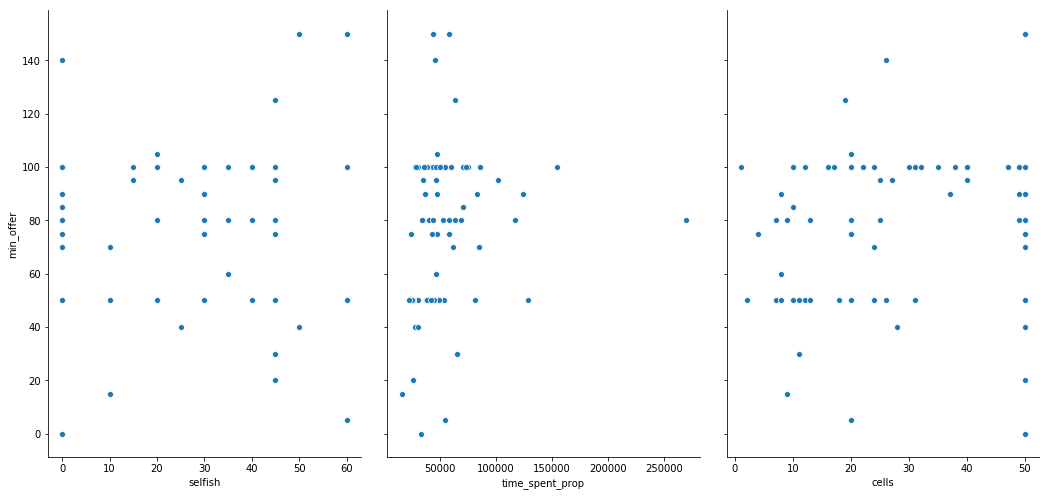

In [26]:
# sb.pairplot(df, x_vars=('prop','other_resp','other_prop'), y_vars='min_offer', height=7, aspect=0.7, kind='reg')

sb.pairplot(df, x_vars=('selfish', 'time_spent_prop', 'cells'), y_vars='min_offer', height=7, aspect=0.7)

## Train model with top features

In [27]:
from utils.preprocessing import df_to_xy
top_columns = ['selfish', 'time_spent_prop']
#top_columns = ['cells', 'time_spent_prop']
x, y = df_to_xy(df, centered=False, select_columns=top_columns, min_target=5, max_target=190)
split = int(x.shape[0] * 0.6)
xTrain, yTrain = x[:split], y[:split]
xTest, yTest = x[split:], y[split:]

In [28]:
from sklearn.svm import SVR
from models import AcceptanceModel
model = AcceptanceModel(SVR(gamma='auto'))
model.fit(xTrain, yTrain)

In [29]:
from models.metrics import gain_mean, avg_loss_ratio, MAX_GAIN
from utils.explanation import generate_decision_area
yPred = model.predict(xTest)
print("Mean gain: ", gain_mean(yTest, yPred))
print("AVG loss ratio: ", avg_loss_ratio(yTest, yPred))
pd.DataFrame(data={"Mean gain: ": [gain_mean(yTest, yPred)], "AVG loss ratio: ": [avg_loss_ratio(yTest, yPred)]})

Mean gain:  97.03125
AVG loss ratio:  0.1711503782542585


,AVG loss ratio:,Mean gain:
0,0.17115,97.03125


In [30]:
print("Unique predicted values: ", np.unique(yPred))

Unique predicted values:  [ 90.  95. 100. 105. 110.]


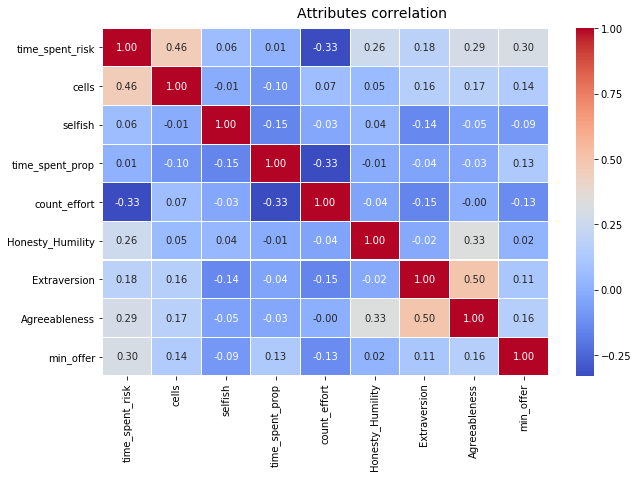

In [31]:
import seaborn as sns
from matplotlib import pyplot as plt
# Correlation Matrix Heatmap
f, ax = plt.subplots(figsize=(10, 6))
corr = df.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Attributes correlation', fontsize=14)

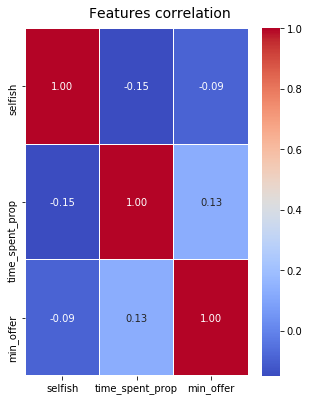

In [32]:
from utils.preprocessing import df_to_xydf
# Correlation Matrix Heatmap
f, ax = plt.subplots(figsize=(5, 6))
df_x, df_y = df_to_xydf(df, select_columns=top_columns, df_min=df_min, df_max=df_max)
df_corr = df_x.copy()
df_corr['min_offer'] = df_y['min_offer']
corr = df_corr.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Features correlation', fontsize=14)

**Validation DATA**

In [33]:
lbl1, lbl2 = top_columns
x1 = xTest[:, 0].ravel()
x2 = xTest[:, 1].ravel()

yPred = model.predict(xTest)

print("Mean gain: ", gain_mean(yTest, yPred))
print("AVG loss ratio: ", avg_loss_ratio(yTest, yPred))

Mean gain:  97.03125
AVG loss ratio:  0.1711503782542585


AVG loss ratio:  0.31158523573417196


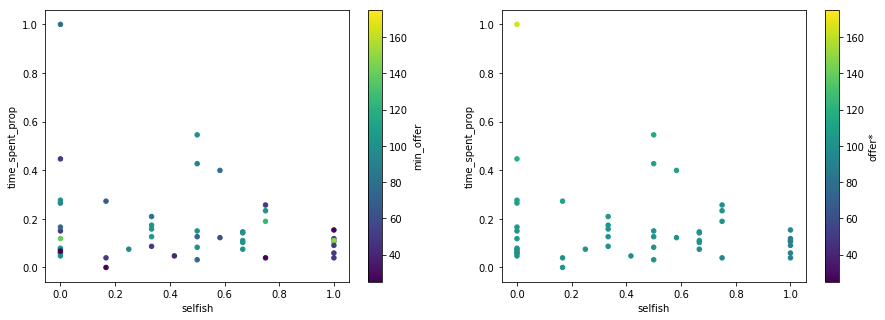

In [34]:
VMIN = 25
VMAX = 175
NB_VALUES = 64
from utils.explanation import generate_decision_area, generate_features_space_df
features_df = generate_features_space_df(nb_features=len(top_columns), nb_values=NB_VALUES, labels=top_columns)

x1 = xTrain[:, 0].ravel()
x2 = xTrain[:, 1].ravel()

yPred = model.predict(xTrain)
print("AVG loss ratio: ", avg_loss_ratio(yTrain, yPred))

fig, ax = plt.subplots(1,2,  figsize=(15, 5),)

out_df_real = pd.DataFrame({lbl1: x1, lbl2: x2, 'min_offer': yTrain.ravel()})
out_df_real.plot.scatter(x=lbl1, y=lbl2, c='min_offer', colormap='viridis', ax=ax[0], vmin=VMIN, vmax=VMAX)

#plt.subplot(1, 1, 1)
out_df_pred = pd.DataFrame({lbl1: x1, lbl2: x2, 'offer*': yPred})
out_df_pred.plot.scatter(x=lbl1, y=lbl2, c='offer*', colormap='viridis', ax=ax[1], vmin=VMIN, vmax=VMAX)

## Generate data for the survey

In [35]:
# Read and sanitize the data
df_test = pd.read_excel("../data/HH_SURVEY1/UG_HH_NEW_continuous_no200_test.xls")

drop_cols = ['prop', 'other_prop', 'other_resp']
df_test = df_test[[col for col in df_test if col not in drop_cols]]

df_features, df_y = df_to_xydf(df_test, centered=False, select_columns=top_columns, df_min=df_min, df_max=df_max)
predictions = model.predict(df_features.values).astype(int)

df_final = df_test[top_columns].copy()
#RESCALE FEATURES
df_final['pred_min_offer'] = predictions.ravel()
df_final['min_offer'] = df_y['min_offer']
df_final.head()

,selfish,time_spent_prop,pred_min_offer,min_offer
0,25,58000,105,100
1,30,66000,110,120
2,30,38000,100,100
3,15,154000,155,90
4,15,83000,114,100


In [36]:
## df_final.to_excel("../data/HH_SURVEY1/UG_HH_NEW_continuous_no200_test_PRED.xls", index=False)

Mean gain:  97.1875
AVG loss ratio:  0.16997769450684652


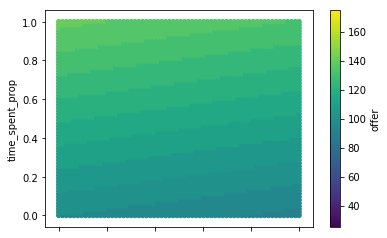

In [37]:
from models.metrics import gain_mean, avg_loss_ratio
model = AcceptanceModel()
model.fit(xTrain, yTrain)
yPred = model.predict(xTest)
print("Mean gain: ", gain_mean(yTest, yPred))
print("AVG loss ratio: ", avg_loss_ratio(yTest, yPred))

out_df = generate_decision_area(model, features_df)
out_df.plot.scatter(x=lbl1, y=lbl2, c='offer', colormap='viridis', vmin=VMIN, vmax=VMAX)

# from mlxtend.plotting import plot_decision_regions
# fig = plot_decision_regions(X=xTest, y=yTest.ravel(), clf=model, legend=2)

Mean gain:  88.4375
AVG loss ratio:  0.2614481946814906


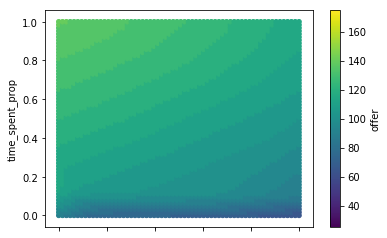

In [38]:
from models.metrics import gain_mean, avg_loss_ratio
from sklearn.neural_network import MLPRegressor
model = AcceptanceModel(MLPRegressor(max_iter=1000))
model.fit(xTrain, yTrain)
yPred = model.predict(xTest)
print("Mean gain: ", gain_mean(yTest, yPred))
print("AVG loss ratio: ", avg_loss_ratio(yTest, yPred))


out_df = generate_decision_area(model, features_df)
out_df.plot.scatter(x=lbl1, y=lbl2, c='offer', colormap='viridis', vmin=VMIN, vmax=VMAX)

# from mlxtend.plotting import plot_decision_regions
# fig = plot_decision_regions(X=xTest, y=yTest.ravel(), clf=model, legend=2)

Mean gain:  83.125
AVG loss ratio:  0.30867576048072776


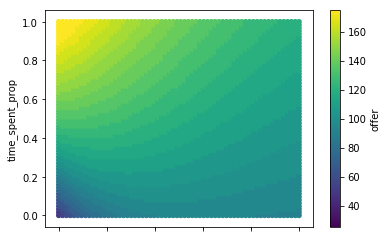

In [39]:
from models.metrics import gain_mean, avg_loss_ratio
from sklearn.svm import SVR
model = AcceptanceModel(SVR(gamma='auto', kernel='sigmoid', degree=3))
model.fit(xTrain, yTrain)
yPred = model.predict(xTest)
print("Mean gain: ", gain_mean(yTest, yPred))
print("AVG loss ratio: ", avg_loss_ratio(yTest, yPred))

out_df = generate_decision_area(model, features_df)
out_df.plot.scatter(x=lbl1, y=lbl2, c='offer', colormap='viridis', vmin=VMIN, vmax=VMAX)

# from mlxtend.plotting import plot_decision_regions
# fig = plot_decision_regions(X=xTest, y=yTest.ravel(), clf=model, legend=2)

Mean gain:  96.875
AVG loss ratio:  0.17057369780155907


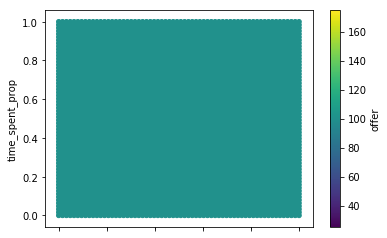

In [40]:
from models.metrics import gain_mean, avg_loss_ratio
from sklearn.svm import SVC
model = SVC(gamma="auto")
model.fit(xTrain, yTrain.ravel())
yPred = model.predict(xTest)
print("Mean gain: ", gain_mean(yTest, yPred))
print("AVG loss ratio: ", avg_loss_ratio(yTest, yPred))

out_df = generate_decision_area(model, features_df)
out_df.plot.scatter(x=lbl1, y=lbl2, c='offer', colormap='viridis', vmin=VMIN, vmax=VMAX)

Mean gain:  61.5625
AVG loss ratio:  0.49894425427513656


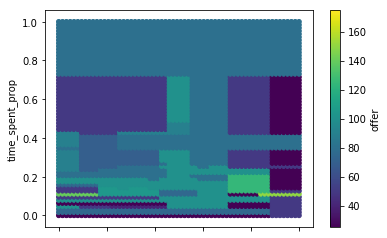

In [41]:
from models.metrics import gain_mean, avg_loss_ratio
from sklearn.ensemble import BaggingClassifier
model = BaggingClassifier()
model.fit(xTrain, yTrain.ravel())
yPred = model.predict(xTest)
print("Mean gain: ", gain_mean(yTest, yPred))
print("AVG loss ratio: ", avg_loss_ratio(yTest, yPred))

out_df = generate_decision_area(model, features_df)
out_df.plot.scatter(x=lbl1, y=lbl2, c='offer', colormap='viridis', vmin=VMIN, vmax=VMAX)

Mean gain:  96.875
AVG loss ratio:  0.17057369780155907


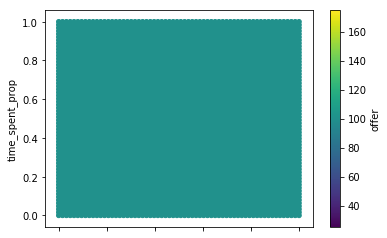

In [42]:
from models.metrics import gain_mean, avg_loss_ratio
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', multi_class='auto')
model.fit(xTrain, yTrain.ravel())
yPred = model.predict(xTest)
print("Mean gain: ", gain_mean(yTest, yPred))
print("AVG loss ratio: ", avg_loss_ratio(yTest, yPred))

out_df = generate_decision_area(model, features_df)
out_df.plot.scatter(x=lbl1, y=lbl2, c='offer', colormap='viridis', vmin=VMIN, vmax=VMAX)

/home/franck/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Mean gain:  101.5625
AVG loss ratio:  0.1399747394682257


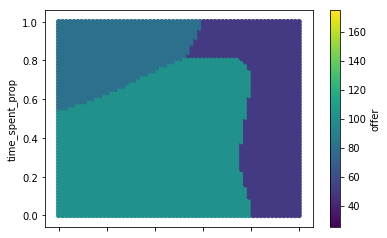

In [43]:
from models.metrics import gain_mean, avg_loss_ratio
from sklearn.neural_network import MLPClassifier
model = MLPClassifier((32, 32, 32, 32, 32))
model.fit(xTrain, yTrain.ravel())
yPred = model.predict(xTest)
print("Mean gain: ", gain_mean(yTest, yPred))
print("AVG loss ratio: ", avg_loss_ratio(yTest, yPred))

out_df = generate_decision_area(model, features_df)
out_df.plot.scatter(x=lbl1, y=lbl2, c='offer', colormap='viridis', vmin=VMIN, vmax=VMAX)

Mean gain:  66.17419
AVG loss ratio:  0.41227922195156497


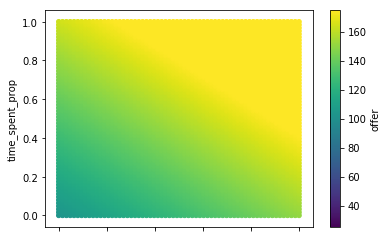

In [44]:
from models.metrics import gain_mean, avg_loss_ratio
from models import KerasModel
model = KerasModel()
model.fit(xTrain, yTrain.ravel())
yPred = model.predict(xTest)
print("Mean gain: ", gain_mean(yTest, yPred))
print("AVG loss ratio: ", avg_loss_ratio(yTest, yPred))

out_df = generate_decision_area(model, features_df)
out_df.plot.scatter(x=lbl1, y=lbl2, c='offer', colormap='viridis', vmin=VMIN, vmax=VMAX)

In [45]:
from mlxtend.evaluate import feature_importance_permutation

coefs:  [ 0.09149791 -0.53258067  2.66449377]


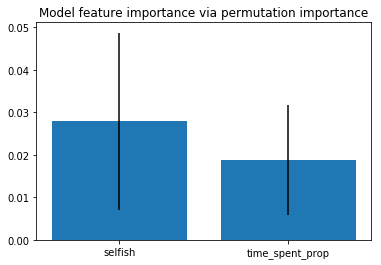

In [122]:
# from utils.benchmark import process_benchmark_cv

# process_benchmark_cv(MLPClassifier(), x, y.ravel())
model = AcceptanceModel()
model.fit(xTrain, yTrain)
print("coefs: ", model.base_model.coef_)

imp_vals, imp_all = feature_importance_permutation(
    predict_method=model.predict, 
    X=xTrain,
    y=yTrain,
    metric='accuracy',
    num_rounds=5,
    seed=5)

imp_df = pd.DataFrame({top_columns[idx]:[imp_vals[idx]] for idx in range(len(top_columns))})

std = np.std(imp_all, axis=1)
indices = np.argsort(imp_vals)[::-1]


plt.figure()
plt.title("Model feature importance via permutation importance")
plt.bar([top_columns[idx] for idx in indices], imp_vals[indices],
        yerr=std[indices])
plt.show()

In [142]:
dx, dy = df_to_xy(df)
model = AcceptanceModel()
model.fit(dx, dy)
model.base_model.coef_

array([-0.30413851,  0.0292734 ,  0.07407528, -0.17325787, -0.05070323,
        0.15611512, -0.07470938, -0.20015294,  2.67350795])

In [143]:
imp_vals, _ = feature_importance_permutation(
    predict_method=model.predict, 
    X=dx,
    y=dy,
    metric='accuracy',
    num_rounds=1,
    seed=1)

imp_vals

array([ 0.03557122,  0.00288415,  0.01281846, -0.012498  , -0.00160231,
       -0.00929338, -0.01634353,  0.00400577])

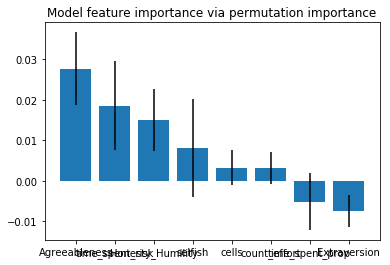

In [163]:
model = AcceptanceModel()
model.fit(dx, dy)
imp_vals, imp_all = feature_importance_permutation(
    predict_method=model.predict, 
    X=dx,
    y=dy,
    metric='accuracy',
    num_rounds=5,
    seed=5)

#imp_df = pd.DataFrame({top_columns[idx]:[imp_vals[idx]] for idx in range(len(top_columns))})

std = np.std(imp_all, axis=1)
indices = np.argsort(imp_vals)[::-1]


plt.figure()
plt.title("Model feature importance via permutation importance")
plt.bar([df.columns[idx] for idx in indices], imp_vals[indices],
        yerr=std[indices],)
plt.show()